# Course project
This is my course project for the FMI Machine learning course. I will do sentiment analysis on a IMDb dataset and try to predict if a review is positive or negative based on the text.
The link of the dataset I use: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Imports

In [1]:
from tensorflow.keras.utils import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Flatten
from sklearn.model_selection import train_test_split 
import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
  
import re 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

import string
from IPython.display import display
from scipy.stats import t


2024-06-28 17:15:20.395107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 17:15:20.395215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 17:15:20.531975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load data

In [2]:
data = pd.read_csv('/kaggle/input/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

In [3]:
data.shape

(50000, 2)

<Axes: xlabel='sentiment', ylabel='count'>

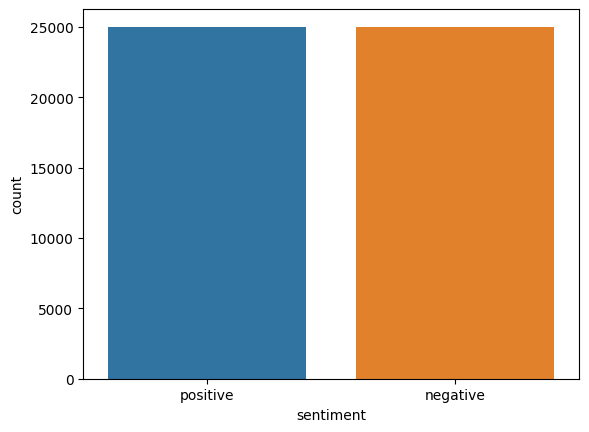

In [4]:
sns.countplot(data=data, x='sentiment')

Data is perfectly balanced

In [5]:
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

## Data preprocessing

In [6]:
data['sentiment'] = [1 if x == 'positive' else 0 for x in data['sentiment']]

In [7]:
def text_preprocess(text : str) -> str:
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'<br />', '', text)
    text = text.replace("\'", "")
    
    tokens = text.split()
    stopwords_english = stopwords.words("english")
    stemmer = PorterStemmer()
    
    cleaned_words = []

    for x in tokens:
        if (x not in stopwords_english and string.punctuation):
            stem_word = stemmer.stem(x)
            cleaned_words.append(stem_word)
    return ' '.join(cleaned_words)

In [8]:
data['cleaned_review'] = data['review'].apply(text_preprocess)
display(data['cleaned_review'][5])
display(data['review'][5])

'probabl all-tim favorit movie, stori selflessness, sacrific dedic nobl cause, preachi boring. It never get old, despit seen 15 time last 25 years. paul luka perform bring tear eyes, bett davis, one truli sympathet roles, delight. the kid are, grandma says, like "dressed-up midgets" children, make fun watch. and mother slow awaken what happen world roof believ startling. If I dozen thumbs, theyd "up" movie.'

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

## Split data

In [9]:
X = data['cleaned_review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
vocab_size = 5000

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Fit tokenizer only on training data.

In [11]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train_sequences[1][:5]

[2, 15, 302, 17, 2]

In [13]:
len(tokenizer.word_index)

93123

Apparently tokenizer.word_index will still shows all unique words found. That's why number of word indexes is much greater than num_words=5000

In [14]:
tokenizer.sequences_to_texts(X_train_sequences[:1])

['that i kept ask mani fights scream <OOV> swear gener mayhem <OOV> <OOV> minutes the comparison also stand think one dimension characters littl depth virtual imposs care happen them they badli written <OOV> director hang <OOV> belief on topic done much better drama tv cinema i must confess im realli one spot bad perform film must said nichola <OOV> a heroin <OOV> best friend <OOV> <OOV> a <OOV> bulli brother absolut terrible i dont know act school graduat from i id appli full <OOV> post <OOV> onli <OOV> <OOV> lead role manag impress cast so cal british talent well probabl never hear again at least that hope next time hire differ <OOV> anoth intrigu thought <OOV> fashion soundtrack featur like snow <OOV> ian brown <OOV> now im bit music fan im familiar artist <OOV> i didnt recognis track movi apart <OOV> run b <OOV> anyone we get many mani music montag <OOV> suppos feel these accompani <OOV> origin imag coupl kiss <OOV> lake <OOV> <OOV> thi problem none song convey mood <OOV> realis di

## Padding

In [15]:
lengths = list(map(len, data['review']))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

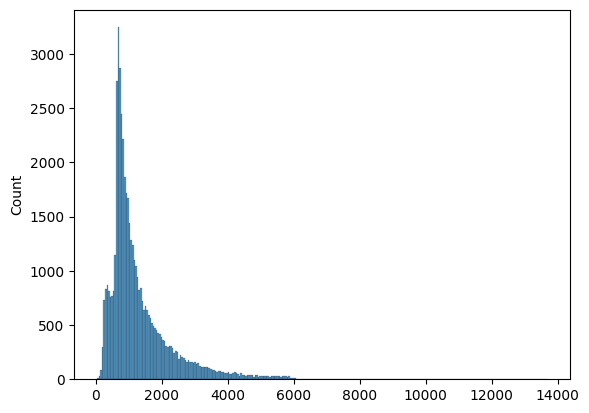

In [16]:
sns.histplot(lengths)

In [17]:
max(lengths)

13704

In [18]:
mean_len = np.mean(lengths)
mean_len

1309.43102

In [19]:
std_len = np.std(lengths)
std_len

989.7181170827175

In [20]:
# max_len = int(mean_len + 0.5*std_len)
max_len = 100

At first I thought that it isn't a good idea of using a size of the review which is too short, because I though it might be possible for people to have biase that is usually to start a review in some way which isn't their true experience, but in the end if I was using a bigger length not only the training of the model was getting super slow, but it could not learn? Never exceeding 55%? For me this felt strange, probably max_len=100 makes it more general while a bigger length is introducing too much noise? I would like to understand why this happens!

In [21]:
len([x for x in lengths if x < max_len]) / len(lengths)


0.0004

80% of the reviews have length that is less than the mean + (0.5*standart deviation). This is the maximum length we will use. At first I tried with a longer length, but training was too slow...

In [22]:
X_train_padded_sequences = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded_sequences = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

X_train_padded_sequences

array([[ 35,   2, 770, ..., 361,  22, 187],
       [  2,  15, 302, ...,  20, 209,   1],
       [ 26, 536,  34, ...,   0,   0,   0],
       ...,
       [614,   7,   6, ...,   0,   0,   0],
       [  9, 326, 116, ...,   0,   0,   0],
       [  9, 514,  17, ...,   0,   0,   0]], dtype=int32)

In [23]:
np.mean(list(map(len, X_train_padded_sequences)))

100.0

## Modelling

In [24]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,113 (1.47 MB)

 Trainable params: 386,113 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train_padded_sequences, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded_sequences, y_test))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5755 - loss: 0.6689 - val_accuracy: 0.7453 - val_loss: 0.5517
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7938 - loss: 0.4668 - val_accuracy: 0.8475 - val_loss: 0.3481
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8842 - loss: 0.2911 - val_accuracy: 0.8621 - val_loss: 0.3161
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9030 - loss: 0.2464 - val_accuracy: 0.8423 - val_loss: 0.3595
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9212 - loss: 0.2103 - val_accuracy: 0.8568 - val_loss: 0.3576
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9357 - loss: 0.1828 - val_accuracy: 0.8524 - val_loss: 0.3941
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9523 - loss: 0.1421 - val_accuracy: 0.8462 - val_loss: 0.4247
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9657 -

We can easily see that there is overfitting. Validation accuracy starts declining after the 3rd epoch, while accuracy on the training set is of course growing. The best accuracy as we can see is 86% on the validation set.

In [26]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    Bidirectional(GRU(64, return_sequences=True)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,721 (1.46 MB)

 Trainable params: 382,721 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X_train_padded_sequences, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded_sequences, y_test))


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7531 - loss: 0.4733 - val_accuracy: 0.8412 - val_loss: 0.3564
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8810 - loss: 0.2837 - val_accuracy: 0.8553 - val_loss: 0.3434
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9533 - loss: 0.1342 - val_accuracy: 0.8398 - val_loss: 0.4540
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9909 - loss: 0.0367 - val_accuracy: 0.8342 - val_loss: 0.6894
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9976 - loss: 0.0110 - val_accuracy: 0.8342 - val_loss: 0.8955


In [28]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,721 (1.46 MB)

 Trainable params: 382,721 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Once again we can easily see that overfitting occurres after the 2nd epoch. Best accuracy on the validation set it 85%. I thought that GRU will be better for NLP than LSTM, but in the end they are pretty much the same in this task.

In [29]:
history = model.fit(X_train_padded_sequences, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded_sequences, y_test))


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7505 - loss: 0.4706 - val_accuracy: 0.8411 - val_loss: 0.3529
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8844 - loss: 0.2787 - val_accuracy: 0.8355 - val_loss: 0.4129
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9481 - loss: 0.1420 - val_accuracy: 0.8407 - val_loss: 0.4406
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9861 - loss: 0.0468 - val_accuracy: 0.8375 - val_loss: 0.6224
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9948 - loss: 0.0180 - val_accuracy: 0.8404 - val_loss: 0.8337


I tried to use dropout to avoid overfitting and it makes some positive impact, because validation accyracy doesn't really drop until the 5th epoch, but still the model didn't perfom much better.